# Homework and bake-off: pragmatic color descriptions

In [ ]:
# http://web.stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

In [ ]:
# !ls -ltra
from google.colab import drive
drive.mount('/content/drive')

# # repo clone if not done
# !git clone https://github.com/cgpotts/cs224u.git

# wget data if not done
# download course dataset
# !cd drive/My\ Drive/cs224u  && wget http://web.stanford.edu/class/cs224u/data/data.tgz
# !cd drive/My\ Drive/cs224u && tar -zxvf data.tgz
# download glove
# !mkdir -p drive/My\ Drive/cs224u/data/glove.6B
# !cd drive/My\ Drive/cs224u/data/glove.6B  && wget http://nlp.stanford.edu/data/glove.6B.zip

# !cd drive/My\ Drive/cs224u/data/glove.6B && unzip glove.6B.zip

# !cd drive/My\ Drive/cs224u && pip install -r requirements.txt
! cp drive/My\ Drive/cs224u/*.py .

Mounted at /content/drive


## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 point]](#Question-3:-GloVe-embeddings-[1-point])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system (not required, but an efficient way to work at the very least).

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [ ]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch_color_describer import (
    ContextualColorDescriber, create_example_dataset)
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [ ]:
utils.fix_random_seeds()

In [ ]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

print (COLORS_SRC_FILENAME)

data/colors/filteredCorpus.csv


## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [ ]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=2,
    normalize_colors=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print (dev_corpus.normalize_colors)

True


In [ ]:
a=[]
a = next(dev_corpus.read())
print (a)
print (type(a))
dev_examples = list(dev_corpus.read())
print (type(dev_examples))

FileNotFoundError: ignored

This subset has about one-third the examples of the full corpus:

Medium pink
None
Medium pink


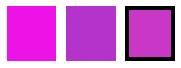

In [ ]:
len(dev_examples)
print (dev_examples[0].display())
print (dev_examples[0].__str__())

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [ ]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])
# print (list(zip(*[[[1,2],[3,4]], [[3,4],[5,6]]])))

NameError: ignored

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [ ]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [ ]:
def tokenize_example(s, n=2):
   if (n==1):    #uni-gram
    return [START_SYMBOL] + s.split() + [END_SYMBOL]
   elif (n==2):  #bi-gram
    print (s)
    lst = [''.join( i for i in s)]
    print (lst)
    bigrams = [str(b[0] + ' ' + b[1]) for l in lst for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
    return [START_SYMBOL] + bigrams + [END_SYMBOL]
   else:
    return -1

In [ ]:
x = dev_texts_train[377]
y = tokenize_example(x, n=1)
print (y)

# y = tokenize_example(x, n=2)
# print (y)

['<s>', 'Olive', 'green', '</s>']


__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [ ]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    print (result)    
    result = func(s, 2)
    print (result)    
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [ ]:
test_tokenize_example(tokenize_example)

A test string
['A test string']
['<s>', 'A test', 'test string', '</s>']
A test string
['A test string']
['<s>', 'A test', 'test string', '</s>']


## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [ ]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]
# print (dev_seqs_train[0:10])
# print (len(dev_seqs_train))
dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]


lime green
['lime green']
lime green
['lime green']
drab purple
['drab purple']
YELLLOW green
['YELLLOW green']
pretty in
['pretty in']
light purple
['light purple']
green again
['green again']
darkest green
['darkest green']
bright green
['bright green']
blood orange
['blood orange']
dull green
['dull green']
baby blue
['baby blue']
blueish gray
['blueish gray']
purple grey
['purple grey']
lime green
['lime green']
neon blue
['neon blue']
yellow/green one
['yellow/green one']
grey purple
['grey purple']
mustard yellow
['mustard yellow']
blue family
['blue family']
not blue
['not blue']
bright green
['bright green']
lighter pink
['lighter pink']
olive green
['olive green']
dull blue
['dull blue']
more purple
['more purple']
dark pink
['dark pink']
not pink ### not blue/gray
['not pink ### not blue/gray']
dark blue
['dark blue']
purplish blue
['purplish blue']
peack dull
['peack dull']
lighter grey
['lighter grey']
brightest pink
['brightest pink']
neon green
['neon green']
olive green


pinkish purple
['pinkish purple']
dark purple
['dark purple']
softest pink
['softest pink']
darker purple
['darker purple']
darkest green
['darkest green']
purple purple
['purple purple']
duller green
['duller green']
purplish blue
['purplish blue']
blueish purplish
['blueish purplish']
dirty green
['dirty green']
bright purple
['bright purple']
bright blue
['bright blue']
the purple
['the purple']
bold purple
['bold purple']
brighter green
['brighter green']
dark purple
['dark purple']
classic blue
['classic blue']
vibrant pink
['vibrant pink']
not purple
['not purple']
purple blue
['purple blue']
army color
['army color']
darker green
['darker green']
neon green
['neon green']
carolina blue
['carolina blue']
palest blue
['palest blue']
neon green
['neon green']
rose pink
['rose pink']
dark orange
['dark orange']
yellowish green
['yellowish green']
dark blue
['dark blue']
vibrant purple
['vibrant purple']
lightest blue
['lightest blue']
darker orange
['darker orange']
light green
['li

['Light green']
pinkish purple
['pinkish purple']
seafoam green
['seafoam green']
green dull
['green dull']
The ocean
['The ocean']
dark pink
['dark pink']
neon green
['neon green']
hot pinkish
['hot pinkish']
mint green
['mint green']
blue green
['blue green']
green brown
['green brown']
not water
['not water']
Brightest green
['Brightest green']
bluish purple
['bluish purple']
light blue
['light blue']
aqua gray
['aqua gray']
lighther green
['lighther green']
sky color
['sky color']
light burgandy
['light burgandy']
brighter teal
['brighter teal']
dull purpe
['dull purpe']
dark blue
['dark blue']
neon pink
['neon pink']
normal blue
['normal blue']
girl color
['girl color']
grey green
['grey green']
blue grey
['blue grey']
Not turquoise ### Light green
['Not turquoise ### Light green']
pastel water
['pastel water']
bright aqua
['bright aqua']
Dusty Purple
['Dusty Purple']
dull purple
['dull purple']
slightly purplish/grey
['slightly purplish/grey']
blue d
['blue d']
lighter green
['li

['not pink ### not bright']
the blue
['the blue']
darker blue
['darker blue']
hot pink
['hot pink']
hot pink
['hot pink']
green green
['green green']
Medium shade
['Medium shade']
bright green
['bright green']
darker blue
['darker blue']
all good
['all good']
purpleish one
['purpleish one']
bright blue
['bright blue']
darkish blue/grey
['darkish blue/grey']
light pink/grey
['light pink/grey']
bright pink
['bright pink']
dark blue
['dark blue']
pastel green
['pastel green']
bright green
['bright green']
gray square
['gray square']
blue-ish gray
['blue-ish gray']
dull green
['dull green']
Neon pink
['Neon pink']
darker blue
['darker blue']
brightest green
['brightest green']
dark blue
['dark blue']
bright yellow
['bright yellow']
bright blue
['bright blue']
neon yellow-green
['neon yellow-green']
brightest green
['brightest green']
haha thanks
['haha thanks']
bright teal
['bright teal']
muted purple
['muted purple']
doesn't matter
["doesn't matter"]
darker green
['darker green']
mint gre

bright purple/pink
['bright purple/pink']
that one
['that one']
dark puprle
['dark puprle']
green lime
['green lime']
grayest blue
['grayest blue']
darker blue
['darker blue']
redish brown
['redish brown']
pink purple
['pink purple']
confederate blue ### gray blue
['confederate blue ### gray blue']
most greenish
['most greenish']
bluest gray
['bluest gray']
dark purple ### not dull
['dark purple ### not dull']
deepest pink
['deepest pink']
darker blue
['darker blue']
purply pink
['purply pink']
pink rose
['pink rose']
bright pink
['bright pink']
grey green
['grey green']
dull pink
['dull pink']
darker blue
['darker blue']
Lightest color
['Lightest color']
darker green
['darker green']
truer green
['truer green']
dull green
['dull green']
bright blue
['bright blue']
Darker purple
['Darker purple']
baby girl
['baby girl']
bright blue
['bright blue']
purple purple
['purple purple']
purpleish pink
['purpleish pink']
Green blue
['Green blue']
more red
['more red']
most gray
['most gray']
br

purpleish grey
['purpleish grey']
light blue
['light blue']
not pink
['not pink']
bright yellow
['bright yellow']
greenish pink
['greenish pink']
lighter brown
['lighter brown']
sky then
['sky then']
olive green
['olive green']
The yellow-green.
['The yellow-green.']
brighter purple
['brighter purple']
darker purple
['darker purple']
light purple
['light purple']
dark blue
['dark blue']
drabest color
['drabest color']
bright blue
['bright blue']
bright yellow
['bright yellow']
brownish one
['brownish one']
darkest purple
['darkest purple']
whats up
['whats up']
light blue
['light blue']
Greenish gray-
['Greenish gray-']
almost fuschia
['almost fuschia']
brightest pink
['brightest pink']
dull red
['dull red']
bright red
['bright red']
lime green
['lime green']
purplish dull
['purplish dull']
brightest pink
['brightest pink']
hot pink
['hot pink']
green yellow
['green yellow']
bright green
['bright green']
bright green
['bright green']
aqua blue
['aqua blue']
purple darker
['purple darke

['lighter green']
dark green
['dark green']
dark green
['dark green']
dark blue
['dark blue']
bright green
['bright green']
iridescent pink
['iridescent pink']
Dark Blue
['Dark Blue']
light brown
['light brown']
Gray Purple
['Gray Purple']
pinkish rust
['pinkish rust']
green gray
['green gray']
dull green
['dull green']
yellow green
['yellow green']
grayish purple
['grayish purple']
hot pink
['hot pink']
dreary day
['dreary day']
Light pink
['Light pink']
hot pink
['hot pink']
lighter purple
['lighter purple']
dark blue
['dark blue']
orange looking
['orange looking']
hot pink
['hot pink']
purple looking
['purple looking']
bright green
['bright green']
darker blue
['darker blue']
dullest color
['dullest color']
lime green
['lime green']
pure gray
['pure gray']
most blue
['most blue']
dull lue ### duller one
['dull lue ### duller one']
nice work ### dark barney
['nice work ### dark barney']
vibrant purple
['vibrant purple']
purpley one
['purpley one']
dullish blue
['dullish blue']
bright

bright green
['bright green']
hot pink
['hot pink']
gray blue
['gray blue']
darker grey
['darker grey']
brighter purple
['brighter purple']
grey blue
['grey blue']
the yellow
['the yellow']
bright pink
['bright pink']
and you?
['and you?']
yellow green
['yellow green']
bright green
['bright green']
bluest grey
['bluest grey']
hot pink
['hot pink']
pink bright
['pink bright']
dark blue
['dark blue']
dark green
['dark green']
bright blue
['bright blue']
crap sorry ### green B
['crap sorry ### green B']
light pink
['light pink']
purpley blue
['purpley blue']
middle hue
['middle hue']
most purpley
['most purpley']
more blue
['more blue']
dull purple
['dull purple']
Lighter Blue
['Lighter Blue']
faded blue
['faded blue']
sorry......bright pink
['sorry......bright pink']
grayish green
['grayish green']
lighter green
['lighter green']
Brightest one
['Brightest one']
bright purple
['bright purple']
mint green
['mint green']
dull red
['dull red']
darker pink
['darker pink']
fire engine
['fire e

greenish gray
['greenish gray']
blue gray
['blue gray']
lighter green
['lighter green']
not sure ### Bright purple
['not sure ### Bright purple']
not neon
['not neon']
yay lol
['yay lol']
dark purple
['dark purple']
purplish blue
['purplish blue']
green dark
['green dark']
bright purple
['bright purple']
lightest purple
['lightest purple']
Lime Green
['Lime Green']
purple bright
['purple bright']
lighter green
['lighter green']
grey bluish
['grey bluish']
Choose yellow
['Choose yellow']
mint green
['mint green']
puke green
['puke green']
gray pink
['gray pink']
Brightest blue
['Brightest blue']
leaf green
['leaf green']
vomit green
['vomit green']
bright yellow
['bright yellow']
brightest pink
['brightest pink']
darker blue
['darker blue']
neon green
['neon green']
dull orangidh
['dull orangidh']
reddish one
['reddish one']
purplish blue
['purplish blue']
tanish brown
['tanish brown']
dark blue
['dark blue']
dull sky
['dull sky']
bright green
['bright green']
dark green
['dark green']


mint green
['mint green']
schoolbus yellow
['schoolbus yellow']
deep blue
['deep blue']
not gold
['not gold']
dark purple
['dark purple']
lime green
['lime green']
pale purple
['pale purple']
greeny gray
['greeny gray']
darkest blue
['darkest blue']
darker one
['darker one']
grey purple
['grey purple']
not greenish
['not greenish']
brownish gray
['brownish gray']
dull green
['dull green']
yellow green
['yellow green']
bright purple
['bright purple']
tealish shade
['tealish shade']
brightest green
['brightest green']
greenish blue
['greenish blue']
bright purple
['bright purple']
sharper purple
['sharper purple']
yellow green
['yellow green']
gray purple
['gray purple']
bright green
['bright green']
darker purple
['darker purple']
bright blue
['bright blue']
dull yellow
['dull yellow']
Pale brown
['Pale brown']
medium blue
['medium blue']
blue grey
['blue grey']
dark blue
['dark blue']
muted greenish
['muted greenish']
light green
['light green']
not pink
['not pink']
pink purple
['pink

brighter blue ### baby bluish
['brighter blue ### baby bluish']
army green
['army green']
darker orange
['darker orange']
yellow beige
['yellow beige']
green blue
['green blue']
bright blue
['bright blue']
Blue pale
['Blue pale']
bright purple
['bright purple']
greenish blue
['greenish blue']
dull brown
['dull brown']
Light Blue
['Light Blue']
army green
['army green']
bright pink
['bright pink']
bluish green
['bluish green']
teal blue
['teal blue']
dull gray
['dull gray']
light blue
['light blue']
brownish, dull
['brownish, dull']
orange est.
['orange est.']
l green ### not yellow
['l green ### not yellow']
not greyish ### slightly darker ### than all
['not greyish ### slightly darker ### than all']
darker green
['darker green']
dark purple
['dark purple']
brown grey
['brown grey']
yellow green
['yellow green']
bright pink
['bright pink']
purple bllue
['purple bllue']
darker green
['darker green']
bright green
['bright green']
lime green
['lime green']
blueish gray
['blueish gray']
br

['brighter pink']
bright blue
['bright blue']
duller one
['duller one']
deepest blue
['deepest blue']
Hello! :)
['Hello! :)']
darker blue
['darker blue']
darker pink
['darker pink']
gray ish
['gray ish']
Rose colored
['Rose colored']
nice work! ### orange tan
['nice work! ### orange tan']
purple gray
['purple gray']
most yellow
['most yellow']
purple grey
['purple grey']
lightest blu-grn
['lightest blu-grn']
redish tanish
['redish tanish']
bright yellow
['bright yellow']
true purple
['true purple']
dul yellow
['dul yellow']
dull blue
['dull blue']
brightest purple
['brightest purple']
bronze like
['bronze like']
most grey
['most grey']
neon pink
['neon pink']
pink bright
['pink bright']
olive green
['olive green']
military green
['military green']
bluish gray
['bluish gray']
lightest blue
['lightest blue']
peach color
['peach color']
bluish green
['bluish green']
brighter green
['brighter green']
pink puirple
['pink puirple']
neon pink
['neon pink']
dark green
['dark green']
Teal-ish c

blueish one
['blueish one']
bright purple
['bright purple']
forest green
['forest green']
yellower green
['yellower green']
dullest green
['dullest green']
gray blue
['gray blue']
darker grey
['darker grey']
true purple
['true purple']
less green..?
['less green..?']
blueish gray
['blueish gray']
brightest blue
['brightest blue']
neon green
['neon green']
Greyish purple
['Greyish purple']
bold red
['bold red']
yellow orange
['yellow orange']
dark green
['dark green']
same color ### medium grey
['same color ### medium grey']
mouse color
['mouse color']
pinkest blue
['pinkest blue']
bright blue
['bright blue']
blue darker
['blue darker']
darker green
['darker green']
grayest color
['grayest color']
brownish red
['brownish red']
green :)
['green :)']
light green
['light green']
red orange
['red orange']
brightest one
['brightest one']
Barney Purple
['Barney Purple']
bluish green
['bluish green']
greyish brown
['greyish brown']
dull purple
['dull purple']
light poop
['light poop']
lighter 

['blue purple']
hot pink
['hot pink']
greenish grey
['greenish grey']
pale neon
['pale neon']
not pink
['not pink']
brightest blue
['brightest blue']
Darker purple
['Darker purple']
pale green
['pale green']
blue grey ### almost purple
['blue grey ### almost purple']
richest blu/purp
['richest blu/purp']
bright blue
['bright blue']
vibrant green
['vibrant green']
Like inbetween ### greenish brown
['Like inbetween ### greenish brown']
light purple
['light purple']
purplish gray
['purplish gray']
bright green
['bright green']
neon green
['neon green']
Middle shade
['Middle shade']
sharp green
['sharp green']
brightest green
['brightest green']
more blue
['more blue']
green..no yellow
['green..no yellow']
bright green
['bright green']
blue green
['blue green']
seafoam green
['seafoam green']
Not tan
['Not tan']
aqua blue
['aqua blue']
Sandy Tan
['Sandy Tan']
lighter blue
['lighter blue']
neon green
['neon green']
light gray?
['light gray?']
light purple
['light purple']
light sky
['light 

darker blue
['darker blue']
lighter orange
['lighter orange']
more army
['more army']
purple grey
['purple grey']
hot pink
['hot pink']
light blue
['light blue']
ballet slippers
['ballet slippers']
bright green
['bright green']
steel gray
['steel gray']
will do!
['will do!']
Gray Box
['Gray Box']
hot pink
['hot pink']
bright blue
['bright blue']
greyish brown
['greyish brown']
light purple
['light purple']
browner yellow
['browner yellow']
medium dull
['medium dull']
bright magenta
['bright magenta']
drab green
['drab green']
pinkish gray
['pinkish gray']
drab purple
['drab purple']
yellower green
['yellower green']
dull blue
['dull blue']
lime green
['lime green']
neoon green
['neoon green']
more faded
['more faded']
purple pink
['purple pink']
dull green
['dull green']
bright pink
['bright pink']
purple gray
['purple gray']
neon green
['neon green']
grayish pink
['grayish pink']
caribbean water
['caribbean water']
light green
['light green']
greenest one
['greenest one']
reddish brow

dark green
['dark green']
brighter blue
['brighter blue']
hot purple
['hot purple']
gray blue
['gray blue']
mustard green
['mustard green']
lighter purple
['lighter purple']
purplish grey
['purplish grey']
bright purple
['bright purple']
green bright
['green bright']
The blue
['The blue']
blueish purple
['blueish purple']
royal blue
['royal blue']
darkest red
['darkest red']
neon green
['neon green']
bright blue
['bright blue']
yellowish green
['yellowish green']
brownish green
['brownish green']
most green ### less gray
['most green ### less gray']
sagey color
['sagey color']
middle brightness
['middle brightness']
Light rose?
['Light rose?']
darkest blue
['darkest blue']
muted purple
['muted purple']
light aqua
['light aqua']
choose orange
['choose orange']
blue teal
['blue teal']
lightest purple
['lightest purple']
brightest green
['brightest green']
dark green
['dark green']
blue greenish
['blue greenish']
bright purple
['bright purple']
light blue
['light blue']
bright mustard
['b

light pink
['light pink']
darker/brighter teal
['darker/brighter teal']
pale red
['pale red']
darker blue
['darker blue']
last one ### lighter blue ### u too
['last one ### lighter blue ### u too']
darkest purple
['darkest purple']
light blue
['light blue']
darkest green
['darkest green']
teal blue
['teal blue']
pink bright ### not neon
['pink bright ### not neon']
greyest one
['greyest one']
dark gray
['dark gray']
Darkest one
['Darkest one']
green gray
['green gray']
orange tint
['orange tint']
mint green
['mint green']
golden brown
['golden brown']
mustard brown
['mustard brown']
bright pink
['bright pink']
take care
['take care']
lime green
['lime green']
Lighter green
['Lighter green']
bright pink
['bright pink']
bright purple
['bright purple']
brighter green
['brighter green']
bright yellow
['bright yellow']
dusty blue
['dusty blue']
dingy green ### not blueish
['dingy green ### not blueish']
bright blue
['bright blue']
gray green
['gray green']
greyish blue
['greyish blue']
The 

We use only the train set to derive a vocabulary for the model:

In [ ]:
# print (len(dev_seqs_train))
# #prints 10417 list elements

dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})
dev_vocab += [UNK_SYMBOL]


# print (len(dev_vocab))
# #prints 3305 elements

# dev_vocab1 = [w for toks in dev_seqs_train for w in toks]
# dev_vocab1 += [UNK_SYMBOL]
# print (len(dev_vocab1))
# #prints 32587 elements
# print (type(dev_vocab1))

It's important that the `UNK_SYMBOL` is included somewhere in this list. In test examples, words not seen in training will be mapped to `UNK_SYMBOL`. 

Conceptual note: If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [ ]:
print (len(dev_vocab))

3305


## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [ ]:
from colors import ColorsCorpusExample
import numpy as np
from scipy.fft import fft
from itertools import product
import colorsys
import cmath

def _convert_hls_to_hsv(normalize_colors, h, l, s):
     if not normalize_colors:
            h, l, s = _scale_color_rgb(h, l, s)
     a ,b, c = colorsys.hls_to_rgb(h, l, s)
     s_a, s_b, s_c = _scale_color_hsv(a, b, c)
     return colorsys.rgb_to_hsv(s_a, s_b, s_c)

def _scale_color_hsv(h, l, s):
     return [h/360, l/200, s/200]

def _scale_color_rgb(h, l, s):
     return [h/360, l/100, s/100]
        
def hls_to_hsv(normalize_colors, colors):
     print (colors)  
     hsv = []        
     for item in colors:
            hsv.append(_convert_hls_to_hsv(normalize_colors, item[0], item[1], item[2]))      
     return hsv      
     
def represent_color_context(colors):
    
     proj_54D = {}
     proj_54D_lst = []
    
     hsv = hls_to_hsv(dev_corpus.normalize_colors, colors)    
            
     for color in hsv:    
        
       RealValList = []
       ImagValList = []
        
       for j, k, l in product((0, 1, 2), repeat=3):  
        
         val = -1 * 2 * 3.14 * 1j  * (j * color[0] + k * color[1] + l * color[2])  
         c_num = cmath.exp(val)       
         RealValList.append(c_num.real)
         ImagValList.append(c_num.imag)    
        
       proj_54D[color] = RealValList + ImagValList   # just collect it. Don't return
       proj_54D_lst.append(RealValList + ImagValList)
        
     return proj_54D_lst       

In [ ]:
colorLst_54D = represent_color_context(dev_rawcols_train[0])
# print (colorLst_54D)

[[0.19444444444444445, 0.5, 0.11], [0.7472222222222222, 0.5, 0.27], [0.2722222222222222, 0.5, 0.73]]


__Your task__: Modify `represent_color_context` and/or `represent_color` to represent colors in a new way.
    
__Notes__:

* You are not required to keep `represent_color`. This might be unnatural if you want to perform an operation on each color trio all at once.
* For that matter, if you want to process all of the color contexts in the entire data set all at once, that is fine too, as long as you can also perform the operation at test time with an unknown number of examples being tested.

* The Fourier-transform method of [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) is a proven choice for our task. __It is not required that you implement this.__ However, if you decide to, you might find that the overly terse presentation in the paper is an obstacle. They key thing to see is that the notation $\hat{f}_{jkl}$ is meant to specify a full coordinate system. Thus, you might do something like

  ```
from itertools import product
for j, k, l in product((0, 1, 2), repeat=3):    
    f_jkl = ...
```
and collect these `f_jkl` values in a list of 27 values. Additionally, in Python, [`2j` produces a value with `real` and `imag` attributes](https://docs.python.org/3.7/library/cmath.html). Each element `f_jkl` should have these components. If you concatenate the `real` and `imag` parts of all the `f_jkl`, you will have a 54-dimensional representation, as in the paper. Remember to start with an HSV representation, and with $h$ in $[0, 360]$, $s$ in $[0, 200]$, and $v$ in $[0, 200]$ (or else do the scaling differently). Note that the values in our corpus are in HLS format, [which are easily converted to HSV](https://en.wikipedia.org/wiki/HSL_and_HSV#HSV_to_HSL).

The following test seeks to ensure only that the output of your `represent_color_context` will be compatible with the models we are creating:

In [ ]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))

In [ ]:
test_represent_color_context(represent_color_context)

[[0.786, 0.58, 0.87], [0.689, 0.44, 0.92], [0.628, 0.32, 0.81]]


## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [ ]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]
dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [ ]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True)

In [ ]:
print (dev_cols_train[0])

if 'IS_GRADESCOPE_ENV' not in os.environ:
    print ("here")
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

[[1.0, 0.9998481536785399, 0.99939266082877, -0.9724600717105572, -0.9763739044546826, -0.9799912196272856, 0.891357182142604, 0.899121120606095, 0.9066120026001635, -0.9005163935930985, -0.9079569140014504, -0.9151216945749314, 0.7743724603571989, 0.785280902883758, 0.795950861377486, -0.6055762030661863, -0.6193517322610911, -0.6329391688915281, 0.6218595502598409, 0.6354120177904704, 0.6487715153660745, -0.42221011888680193, -0.43794274879014594, -0.453542378702662, 0.1993054147193231, 0.21635165599669662, 0.23333219286786036, -0.0, -0.01742611791578899, -0.03484694364777229, -0.23306953668100427, -0.21608794205118953, -0.19904072310315093, 0.4533016367087115, 0.43769990916156254, 0.42196525537219426, -0.43482206115844624, -0.41906353016811515, -0.40317773266675583, 0.632730031403867, 0.619139647871197, 0.6053612361825276, -0.7957873222664087, -0.7851136425672309, -0.7742015296309492, 0.7831287887382435, 0.7721732756625568, 0.7609832592439911, -0.9064979953147125, -0.899002863611752

Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 58.702409744262695

Wall time: 5min 23s


The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [ ]:
dev_mod.evaluate(dev_cols_test, dev_seqs_test)

{'listener_accuracy': 0.38295421825511083, 'corpus_bleu': 0.5684820798781273}

We can also see the model's predicted sequences given color context inputs:

In [ ]:
dev_mod.predict(dev_cols_test[:1])

[['<s>', '</s>']]

In [ ]:
dev_seqs_test[:1]

[['<s>', 'right side', 'side ###', '### purple', 'purple pinkish', '</s>']]

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't mean to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [ ]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [ ]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    # Use `utils.glove2dict` to read in the GloVe file:

    ##### YOUR CODE HERE
    GLOVE_HOME = os.path.join('data', 'glove.6B')
    glove_lookup = utils.glove2dict(os.path.join(GLOVE_HOME, glove_base_filename))        
    
    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.

    ##### YOUR CODE HERE
    embedding, vocab =utils.create_pretrained_embedding(glove_lookup, vocab)
    
    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.

    ##### YOUR CODE HERE
    return embedding, vocab

In [ ]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)

In [ ]:
test_create_glove_embedding(create_glove_embedding)

## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [ ]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [ ]:
len(dev_vocab)

3305

In [ ]:
len(dev_glove_vocab)

3305

In [ ]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

In [ ]:
_ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

Finished epoch 86 of 1000; error is 47.329750299453735

KeyboardInterrupt: 

In [ ]:
dev_mod_glove.listener_accuracy(dev_cols_test, dev_seqs_test)

You probably saw a small boost, assuming your tokeization scheme leads to good overlap with the GloVe vocabulary. The input representations are larger than in our previous model (at least as I configured things), so we would need to do more runs with higher `max_iter` values to see whether this is worthwhile overall.

## Question 4: Color context [3 points]

The final required homework question is the most challenging, but it should set you up to think in much more flexible ways about the underlying model we're using.

The question asks you to modify various model components in `torch_color_describer.py`. The section called [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model) from the core unit notebook provides a number of examples illustrating the basic techniques, so you might review that material if you get stuck here.

__Your task__: Building on ideas from [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142), you will redesign the model so that the target color (the final one in the context) is appended to each input token that gets processed by the decoder. The question asks you to subclass the `Decoder` and `EncoderDecoder` from `torch_color_describer.py` so that you can build models that do this.

__Step 1__: Modify the `Decoder` so that the input vector to the model at each timestep is not just a token representation `x` but the concatenation of `x` with the representation of the target color.

__Notes__:

* You might notice at this point that the original `Decoder.forward` method has an optional keyword argument `target_colors` that is passed to `Decoder.get_embeddings`. Because this is already in place, all you have to do is modify the `get_embeddings` method to use this argument.

* The change affects the configuration of `self.rnn`, so you need to subclass the `__init__` method as well, so that its `input_size` argument accomodates the embedding as well as the color representations.

* You can do the relevant operations efficiently in pure PyTorch using `repeat_interleave` and `cat`, but the important thing is to get a working implementation – you can always optimize the code later if the ideas prove useful to you. 

Here's skeleton code for you to flesh out:

In [ ]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn

class ColorContextDecoder(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Fix the `self.rnn` attribute:
        ##### YOUR CODE HERE
        self.rnn = nn.GRU(
            input_size=self.embed_dim + self.color_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)

    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.

        """
        ##### YOUR CODE HERE
        temp = []
        colors_row = -1
        lst_embeddings = list(self.embedding.parameters())  
        
        """
        print (lst_embeddings)
        for i in lst_embeddings:
            emb_rows = i.size()[0]         
        print (f"emb_rows = {emb_rows}")
        """
        
        batch_size = word_seqs.shape[0]
        
        """
        assert emb_rows == word_seqs.shape[1], \
               "ERROR?: emb_rows {}; word_seqs.shape[1] {}".format(emb_rows, word_seqs.shape[1])        
        row_size = emb_rows
        """
        
        col_size = self.embed_dim + self.color_dim    
        tensor_to_build = torch.zeros([batch_size, word_seqs.shape[1], col_size])  
        
        """
        print (f"Shape of tensor_to_build (with concatenated color): {tensor_to_build.size()}")
        """
        
        for row in word_seqs:              
                        
            colors_row +=1
           
            for rs, item in enumerate(row):  
                row_to_extract = int(item)               
                tensor_to_build[colors_row][rs] = torch.cat((lst_embeddings[0][row_to_extract], target_colors[colors_row]))   
                
        return tensor_to_build

Step 1 is the most demanding of the steps in terms of tensor wrangling. It's important to have a clear idea of what you are trying to achieve and to unit test `get_embeddings` so that you can check that it has realized your vision. The following test should help with that:

In [ ]:
def test_get_embeddings(decoder_class):
    """
    It's assumed that the input to this will be `ColorContextDecoder`.
    You pass in the class, and the function initalizes it with the test
    parameters.
    """
    dec = decoder_class(
        color_dim=3,   # For these, we mainly want *different*
        vocab_size=10, # dimensions so that we reliably get
        embed_dim=4,   # dimensionality errors if something
        hidden_dim=5)  # isn't working.

    # This step just changes the embedding to one with values
    # that are easy to inspect and definitely will not change
    # between runs:
    dec.embedding = nn.Embedding.from_pretrained(
        torch.FloatTensor([
            [10, 11, 12, 13],
            [14, 15, 16, 17],
            [18, 19, 20, 21]]))

    # These are the incoming sequences -- lists of indices
    # into the rows of `dec.embedding`:
    word_seqs = torch.tensor([
        [0,1,2],
        [2,0,1]])

    # Target colors as small floats that will be easy to track:
    target_colors = torch.tensor([
        [0.1, 0.2, 0.3],
        [0.7, 0.8, 0.9]])

    # The desired return value: one list of tensors for each of
    # the two sequences in `word_seqs`. Each index is replaced
    # with its vector from `dec.embedding` and has the
    # corrresponding color from `target_colors` appended to it.
    expected = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

    result = dec.get_embeddings(word_seqs, target_colors=target_colors)

    assert expected.shape == result.shape, \
        "Expected shape {}; got shape {}".format(expected.shape, result.shape)

    assert torch.all(expected.eq(result)), \
        ("Your result has the desired shape but the values aren't correct. "
         "Here's what your function creates; compare it with `expected` "
         "from the test:\n{}".format(result))

In [ ]:
test_get_embeddings(ColorContextDecoder)

In [ ]:
def test_extraction():        
    
        color_seqs = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

        print (color_seqs.size())
        m = color_seqs.size()[0]
        color_dim = color_seqs.size()[2] #is color_dim the dimensionality of the color or the tensor which has color appended to it
        target_colors = torch.zeros([m, 3])      
        batch = -1
        
        for item in color_seqs:
            batch += 1
            for row in item:
                target_colors[batch] = row[:][:][-3:] #hardcoded 3? Only last tensor written into target_colors remains(hack)
        
        print (f"Calling forward with target_colors matrix =\n {target_colors}")

test_extraction()

torch.Size([2, 3, 7])
Calling forward with target_colors matrix =
 tensor([[0.1000, 0.2000, 0.3000],
        [0.7000, 0.8000, 0.9000]])


__Step 2__: Modify the `EncoderDecoder`. For this, you just need to make a small change to the `forward` method: extract the target colors from `color_seqs` and feed them to the decoder.

In [ ]:
from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None):
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.

        ##### YOUR CODE HERE
        
        """
        
        # Forward method of the EncoderDecoder calls the forward method of the Decoder.

        Called: def forward(self, word_seqs, seq_lengths=None, hidden=None, target_colors=None):
        Caller: output, hidden = self.decoder(word_seqs, seq_lengths=seq_lengths, hidden=hidden, target_colors=target_colors)
        
        There is not explicit call to the forward method: refer response to slack question
        
        target_colors : torch.FloatTensor
            Dimension (m, c), where m is the number of examples and
            c is the dimensionality of the color representations.
            
        color_seqs : torch.FloatTensor
            Dimension (m, n, p), where m is the number of examples,
            n is the number of colors in each context, and p is the
            dimensionality of each color.
            
        word_seqs : torch.LongTensor
            Dimension (m, k), where m is the number of examples and k
            is the length of all the (padded) sequences in the batch.
            
        color_seqs : torch.FloatTensor
            Dimension (m, n, p), where m is the number of examples,
            n is the number of colors in each context, and p is the
            dimensionality of each color.
        """

        m = color_seqs.size()[0]
        color_dim = color_seqs.size()[2] #is color_seqs.size()[2] the dimensionality of the color or the tensor which has color appended to it
        target_colors = torch.zeros([m, color_dim]) #should you use color_dim instead, or is color_dim len = emb_dim + color_dim?     
        batch = -1
        for item in color_seqs:
            batch += 1
            for row in item:
                target_colors[batch] = row[:][:][-color_dim:]           
        output, hidden = self.decoder(
           word_seqs, seq_lengths, hidden, target_colors)
        
        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        
        if self.training:
            return output
        else:
            return output, hidden    


__Step 3__: Finally, as in the examples in [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model), you need to modify the `build_graph` method of `ContextualColorDescriber` so that it uses your new `ColorContextDecoder` and `ColorizedEncoderDecoder`. Here's starter code:

In [ ]:
from torch_color_describer import Encoder

class ColorizedInputDescriber(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:

        ##### YOUR CODE HERE
        decoder = ColorContextDecoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim,
            freeze_embedding=self.freeze_embedding,
            color_dim=self.color_dim)  # The new piece is this argument.

        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:

        ##### YOUR CODE HERE
        return ColorizedEncoderDecoder(encoder, decoder)


That's it! Since these modifications are pretty intricate, you might want to use [a toy dataset](colors_overview.ipynb#Toy-problems-for-development-work) to debug it:

In [ ]:
def test_full_system(describer_class):
    toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
        group_size=50, vec_dim=2)

    toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
        train_test_split(toy_color_seqs, toy_word_seqs)

    toy_mod = describer_class(toy_vocab)

    _ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

    acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

    return acc

In [ ]:
test_full_system(ColorizedInputDescriber)

Finished epoch 1000 of 1000; error is 0.1141517162322998

1.0

If that worked, then you can now try this model on SCC problems!

## Your original system [3 points]

There are many options for your original system, which consists of the full pipeline – all preprocessing and modeling steps. You are free to use any model you like, as long as you subclass `ContextualColorDescriber` in a way that allows its `evaluate` method to behave in the expected way.

So that we can evaluate models in a uniform way for the bake-off, we ask that you modify the function `my_original_system` below so that it accepts a trained instance of your model and does any preprocessing steps required by your model.

If we seek to reproduce your results, we will rerun this entire notebook. Thus, it is fine if your `my_original_system` makes use of functions you wrote or modified above this cell.

In [ ]:
def my_original_system(trained_model, color_seqs_test, texts_test):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `word_seqs_test` is a list of strings, so tokenize each of
    # its elements:
    tok_seqs = [tokenize_example(s) for s in texts_test]

    col_seqs = [represent_color_context(colors)
                for colors in color_seqs_test]


    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL! It's a tempting step, but it's
    # a mistake and will get you disqualified!


    # The following core score calculations are required:
    return trained_model.evaluate(col_seqs, tok_seqs)

If `my_original_system` works on test sets you create from the corpus distribution, then it will work for the bake-off, so consider checking that. For example, this would check that `dev_mod` above passes muster:

In [ ]:
my_original_system(dev_mod, dev_rawcols_test, dev_texts_test)

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best **listener_accuracy** score your system got during development, just to help us understand how systems performed overall.

In [ ]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM 
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

# STOP COMMENT: Please do not remove this comment.

## Bakeoff [1 point]

For the bake-off, we will release a test set. You will evaluate your custom model from the previous question on these new datasets using your `my_original_system` function. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

Systems will be ranked primarily by `listener_accuracy`, but we will also consider their `corpus_bleu` scores as reported by `my_original_system`. However, the BLEU score is just a simple check that your system is speaking some version of English that corresponds in some meaningful way to the gold descriptions, so you should concentrate on `listener_accuracy`.

The cells below this one constitute your bake-off entry.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
# Enter your bake-off assessment code in this cell.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your code in the scope of the above conditional.
    ##### YOUR CODE HERE


In [ ]:
# On an otherwise blank line in this cell, please enter
# the return value of `my_original_system` from your
# bake-off run. You can just paste it in.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please paste in your results in the scope of the above conditional.
    ##### YOUR SCORE HERE
